In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

%matplotlib inline


import warnings 
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv(r"C:\Users\sumee\Downloads\Algerian Forest Fires\Algerian_forest_fires_update_dataset.csv")

In [4]:
data.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

## Drop day, month and year column

In [5]:
data.drop(['day', 'month', 'year'], axis = 1, inplace=True)

In [6]:
data.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [7]:
data['Classes'].value_counts()

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64

In [42]:
data.corr()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
Temperature,1.000000,-0.651400,-0.284510,-0.326492,0.676568,0.485687,0.376284,0.603871,0.459789,0.566670,0.516015,0.269555
RH,-0.651400,1.000000,0.244048,0.222356,-0.644873,-0.408519,-0.226941,-0.686667,-0.353841,-0.580957,-0.432161,-0.402682
Ws,-0.284510,0.244048,1.000000,0.171506,-0.166548,-0.000721,0.079135,0.008532,0.031438,0.032368,-0.069964,-0.181160
Rain,-0.326492,0.222356,0.171506,1.000000,-0.543906,-0.288773,-0.298023,-0.347484,-0.299852,-0.324422,-0.379097,-0.040013
FFMC,0.676568,-0.644873,-0.166548,-0.543906,1.000000,0.603608,0.507397,0.740007,0.592011,0.691132,0.769492,0.222241
DMC,0.485687,-0.408519,-0.000721,-0.288773,0.603608,1.000000,0.875925,0.680454,0.982248,0.875864,0.585658,0.192089
DC,0.376284,-0.226941,0.079135,-0.298023,0.507397,0.875925,1.000000,0.508643,0.941988,0.739521,0.511123,-0.078734
ISI,0.603871,-0.686667,0.008532,-0.347484,0.740007,0.680454,0.508643,1.000000,0.644093,0.922895,0.735197,0.263197
BUI,0.459789,-0.353841,0.031438,-0.299852,0.592011,0.982248,0.941988,0.644093,1.000000,0.857973,0.586639,0.089408
FWI,0.566670,-0.580957,0.032368,-0.324422,0.691132,0.875864,0.739521,0.922895,0.857973,1.000000,0.719216,0.197102


<Axes: >

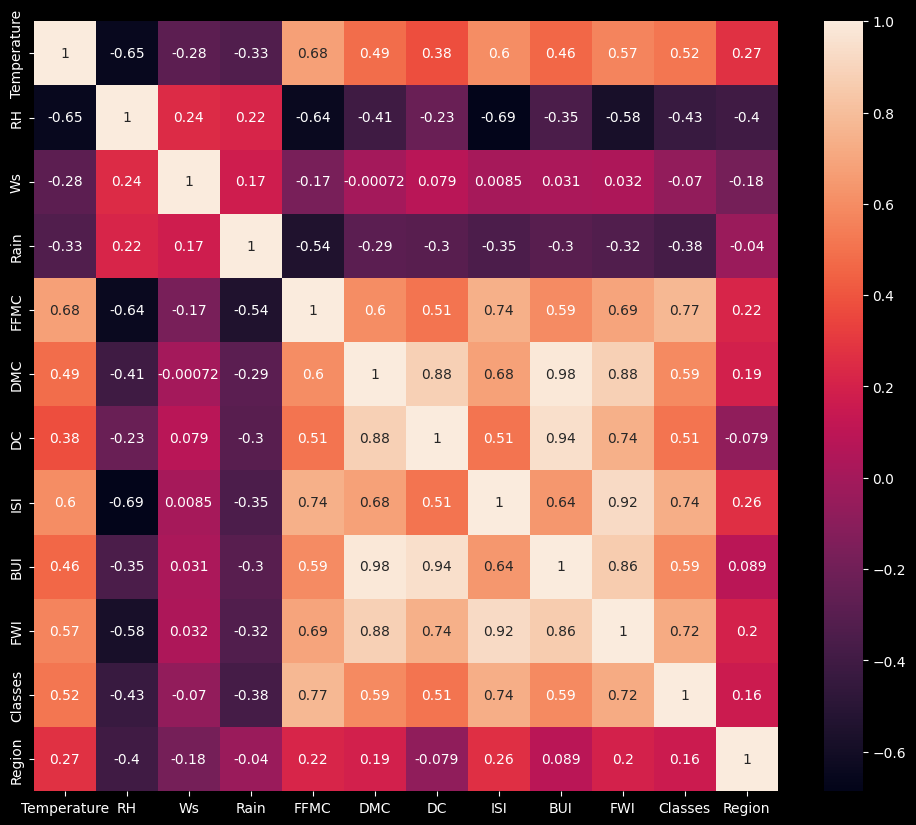

In [43]:
plt.figure(figsize=(12,10))
corr = data.corr()
sns.heatmap(corr, annot=True)

In [44]:
def correlation(dataset, threshold):
    col_corr =set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]>threshold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [45]:
corr_features = correlation(data, 0.85)

In [46]:
corr_features

{'BUI', 'DC', 'FWI'}

In [47]:
data = data.drop('DC', axis=1, inplace=True)

## Feature Engineering

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

## Box PLot to understand the effect of standard scaling

Text(0.5, 1.0, 'After Scaling')

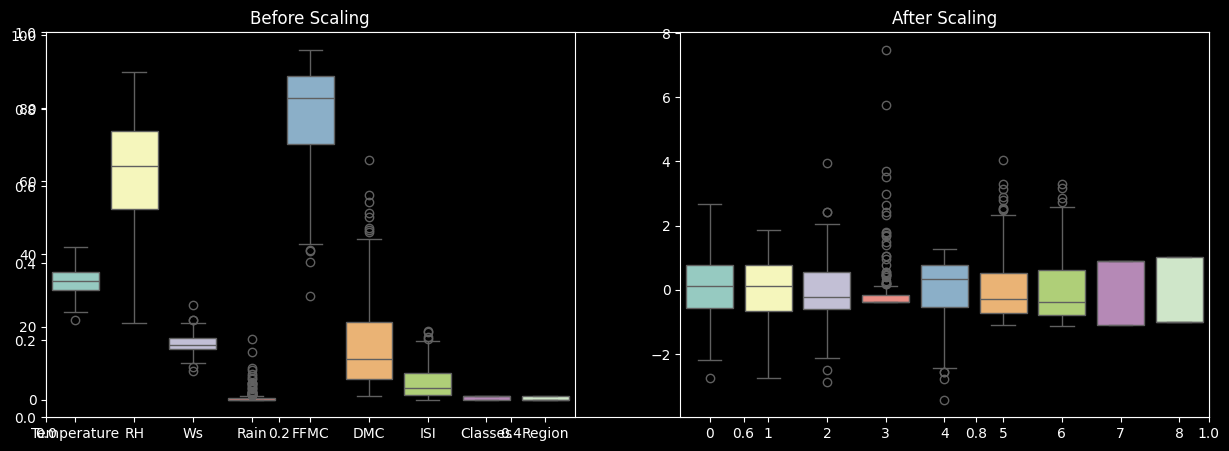

In [24]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title("Before Scaling")
plt.subplot(1,2,2)
sns.boxplot(data=X_train_scaled)
plt.title("After Scaling")

## Linear Regression

Mean absolute error 0.5468236465249977
R2 score 0.9847657384266951


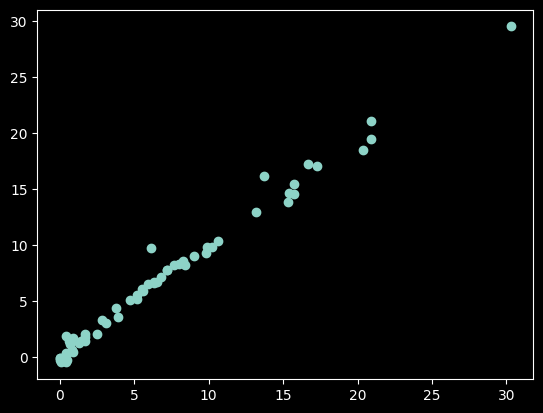

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

linear = LinearRegression()
linear.fit(X_train_scaled, y_train)
y_pred = linear.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)

print("Mean absolute error", mae)
print("R2 score", score)
plt.scatter(y_test, y_pred)

## Lasso

Mean absolute error 1.1331759949144085
R2 score 0.9492020263112388


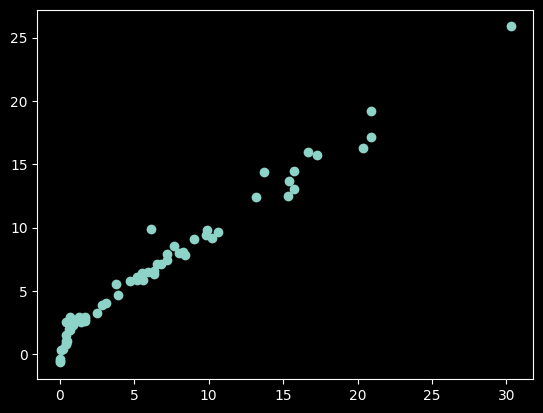

In [26]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

lasso = Lasso()
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)

print("Mean absolute error", mae)
print("R2 score", score)
plt.scatter(y_test, y_pred)

## Cross Validation Lasso

In [27]:
from sklearn.linear_model import LassoCV
la = LassoCV(cv=5)
la.fit(X_train_scaled, y_train)

LassoCV(cv=5)

Mean Absolute error 0.6199701158263433
R2 Score 0.9820946715928275


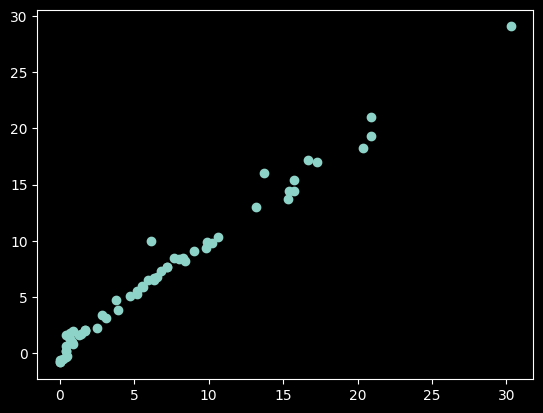

In [28]:
y_pred = la.predict(X_test_scaled)
plt.scatter(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)
print("Mean Absolute error", mae)
print("R2 Score", score)

## Ridge Regression model

Mean Absolute error 0.5642305340105715
R2 Score 0.9834070933284211


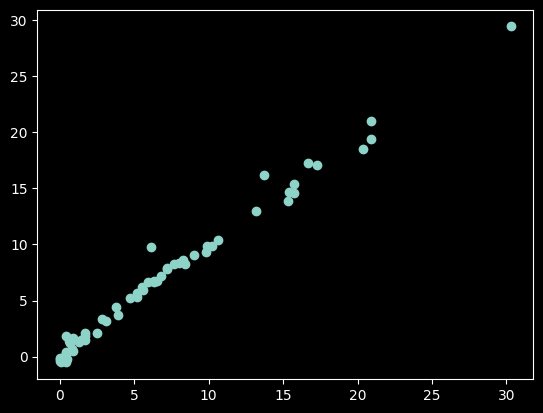

In [29]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r = Ridge()
r.fit(X_train_scaled, y_train)
y_pred = r.predict(X_test_scaled)
mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)
plt.scatter(y_test, y_pred)

In [30]:
from sklearn.linear_model import RidgeCV
rc = RidgeCV(cv=5)
rc.fit(X_train_scaled, y_train)
y_pred = rc.predict(X_test_scaled)
print("Mean Absolute error", mae)
print("R2 Score", score)

Mean Absolute error 0.5642305340105715
R2 Score 0.9834070933284211


In [31]:
rc.get_params()

{'alpha_per_target': False,
 'alphas': (0.1, 1.0, 10.0),
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'scoring': None,
 'store_cv_results': None,
 'store_cv_values': 'deprecated'}

## Elasticnet Regression

Mean Absolute error 1.8822353634896
R2 Score 0.7814447243400926


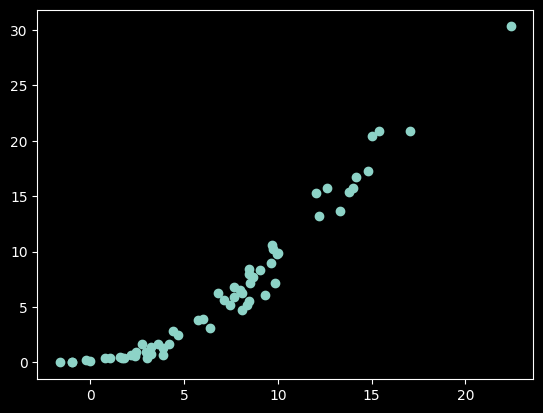

In [32]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

el = ElasticNet()

el.fit(X_train_scaled, y_train)
y_pred = el.predict(X_test_scaled)

plt.scatter(y_pred, y_test)

mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)

Mean Absolute error 0.6575946731430904
R2 Score 0.9799084998743879


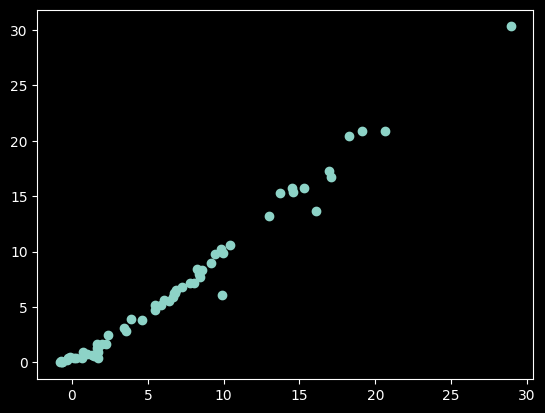

In [33]:
from sklearn.linear_model import ElasticNetCV
e = ElasticNetCV(cv=5)

e.fit(X_train_scaled, y_train)
y_pred = e.predict(X_test_scaled)

plt.scatter(y_pred, y_test)

mae = mean_absolute_error(y_pred, y_test)
score = r2_score(y_pred, y_test)
print("Mean Absolute error", mae)
print("R2 Score", score)

## Pickle the machine learning models, preprocessing model standardscaler

In [34]:
standard

StandardScaler()

In [35]:
r

Ridge()

In [36]:
import joblib

joblib.dump(standard, "scaler.pkl")
joblib.dump(r, "ridge.pkl")


['ridge.pkl']